In [1]:
# !pip install supabase pandas
# !pip install python-dotenv

In [2]:
import os, psycopg2
from supabase import create_client, Client
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [3]:
load_dotenv()

conn = psycopg2.connect(
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT"),
    database=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    sslmode="require"
)
print("✅ Connected successfully!")

✅ Connected successfully!


In [4]:
def reconnect():
    return psycopg2.connect(
        host=os.getenv("DB_HOST"),
        port=os.getenv("DB_PORT"),
        database=os.getenv("DB_NAME"),
        user=os.getenv("DB_USER"),
        password=os.getenv("DB_PASSWORD"),
        sslmode="require"
    )

if conn.closed != 0:
    conn = reconnect()
else:
    print("Connection is still active.")

Connection is still active.


In [5]:
def q(sql, params=None):
    return pd.read_sql(sql, conn, params=params)

In [6]:
# Performance
performance = q("""
SELECT *
FROM performance_yearly
WHERE year = (SELECT MAX(year) FROM performance_yearly)
  AND rating BETWEEN 1 AND 5  -- Include all ratings 1-5
  AND rating IS NOT NULL;
""")

top_perf_ids = performance['employee_id'].unique().tolist()

# Employees
employees = q("""
SELECT 
    e.employee_id,
    e.fullname,
    e.nip,
    c.name AS company_name,
    ar.name AS area_name,
    pos.name AS position_name,
    dep.name AS department_name,
    divs.name AS division_name,
    dir.name AS directorate_name,
    g.name AS grade_name,
    ed.name AS education_name,
    maj.name AS major_name,
    e.years_of_service_months
    
FROM employees e
LEFT JOIN dim_companies c ON e.company_id = c.company_id
LEFT JOIN dim_areas ar ON e.area_id = ar.area_id
LEFT JOIN dim_positions pos ON e.position_id = pos.position_id
LEFT JOIN dim_departments dep ON e.department_id = dep.department_id
LEFT JOIN dim_divisions divs ON e.division_id = divs.division_id
LEFT JOIN dim_directorates dir ON e.directorate_id = dir.directorate_id
LEFT JOIN dim_grades g ON e.grade_id = g.grade_id
LEFT JOIN dim_education ed ON e.education_id = ed.education_id
LEFT JOIN dim_majors maj ON e.major_id = maj.major_id
WHERE e.employee_id = ANY(%s);
""", params=[top_perf_ids])

# Competency yearly + pillar label
competencies = q("""
SELECT 
    cy.employee_id,
    cy.year,
    cy.pillar_code,
    dp.pillar_label,
    cy.score
FROM competencies_yearly cy
LEFT JOIN dim_competency_pillars dp ON cy.pillar_code = dp.pillar_code
WHERE cy.employee_id = ANY(%s);
""", params=[top_perf_ids])

# Profiles (psychometric)
profiles = q("""
SELECT *
FROM profiles_psych
WHERE employee_id = ANY(%s);
""", params=[top_perf_ids])

# Strengths
strengths = q("""
SELECT *
FROM strengths
WHERE employee_id = ANY(%s);
""", params=[top_perf_ids])

# PAPI Score
papiscore = q("""
SELECT *
FROM papi_scores
WHERE employee_id = ANY(%s);
""", params=[top_perf_ids])


C:\Users\ljhab\AppData\Local\Temp\ipykernel_4824\14337282.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(sql, conn, params=params)


In [7]:
print(len(employees), len(performance), len(profiles), len(competencies), len(strengths), len(papiscore))

1790 1790 1790 89500 25060 35800


In [8]:
top_main = employees.merge(performance, on='employee_id', how='left') \
                    .merge(profiles, on='employee_id', how='left')

# Check Missing Value

In [9]:
datasets = {
    "employees": top_main,
    "competencies": competencies,
    "strengths": strengths,
    "papiscore": papiscore
}

for name, df in datasets.items():
    print(f"\n{name.upper()} — shape: {df.shape}")
    null_count = df.isnull().sum()
    null_percent = (df.isnull().mean() * 100).round(1)
    summary = pd.DataFrame({
        "Null Count": null_count,
        "Null %": null_percent
    })
    print(summary[summary["Null Count"] > 0].sort_values("Null %", ascending=False))


EMPLOYEES — shape: (1790, 23)
      Null Count  Null %
iq           404    22.6
gtq          297    16.6
mbti         131     7.3

COMPETENCIES — shape: (89500, 5)
       Null Count  Null %
score        9527    10.6

STRENGTHS — shape: (25060, 3)
       Null Count  Null %
theme        1972     7.9

PAPISCORE — shape: (35800, 3)
       Null Count  Null %
score        2869     8.0


# Imputation

In [10]:
nulls_per_emp = papiscore[papiscore['score'].isnull()].groupby('employee_id').size()

print(f"\n--- Employees with NULL Scores ---")
print(f"Total: {len(nulls_per_emp)}")
print(f"\nNULL count distribution:")
print(nulls_per_emp.value_counts().sort_index())

threshold_nulls = 3
problematic_emps = nulls_per_emp[nulls_per_emp > threshold_nulls].index.tolist()

print(f"\n⚠️ Employees with >{threshold_nulls} NULL scores: {len(problematic_emps)}")



--- Employees with NULL Scores ---
Total: 1468

NULL count distribution:
1    611
2    474
3    259
4     94
5     23
6      7
Name: count, dtype: int64

⚠️ Employees with >3 NULL scores: 124


In [11]:
papiscore_imputed = papiscore.copy()

null_per_user = papiscore_imputed.groupby('employee_id')['score'].apply(lambda x: x.isnull().sum())

users_to_impute = null_per_user[null_per_user <= 3].index
users_to_drop   = null_per_user[null_per_user > 3].index

print(f"Impute for {len(users_to_impute)} employees")
print(f"Drop {len(users_to_drop)} employees (too many missing)")

# imputasi median per scale_code untuk user yang layak
papiscore_imputed = papiscore_imputed[papiscore_imputed['employee_id'].isin(users_to_impute)]

papiscore_imputed['score'] = (
    papiscore_imputed.groupby('scale_code')['score']
    .transform(lambda x: x.fillna(x.median()))
)

Impute for 1666 employees
Drop 124 employees (too many missing)


In [12]:
top_main_imputed = top_main.copy()

top_main_imputed['mbti'] = top_main_imputed['mbti'].fillna('Unknown')

def extract_disc_code(disc_word):
    if pd.isna(disc_word):
        return np.nan
    parts = disc_word.replace('-', ' ').split()
    return ''.join([p[0].upper() for p in parts if p])

top_main_imputed['disc'] = top_main_imputed['disc'].fillna(
    top_main_imputed['disc_word'].apply(extract_disc_code)
)

In [13]:
# Cek missing pattern iq dan gtq random/systematic
print("📊 IQ by Grade:")
print(top_main.groupby('grade_name')['iq'].agg(['count', 'median', 'std']).sort_values('median', ascending=False))

print("\n📊 GTQ by Grade:")
print(top_main.groupby('grade_name')['gtq'].agg(['count', 'median', 'std']).sort_values('median', ascending=False))

print("📊 IQ by Education:")
print(top_main.groupby('education_name')['iq'].agg(['count', 'median', 'std']).sort_values('median', ascending=False))

print("📊 GTQ by Education:")
print(top_main.groupby('education_name')['gtq'].agg(['count', 'median', 'std']).sort_values('median', ascending=False))

print("\n📊 IQ by Department:")
print(top_main.groupby('department_name')['iq'].agg(['count', 'median', 'std']).sort_values('median', ascending=False))

print("\n📊 GTQ by Department:")
print(top_main.groupby('department_name')['gtq'].agg(['count', 'median', 'std']).sort_values('median', ascending=False))

print("📊 IQ by Major:")
print(top_main.groupby('major_name')['iq'].agg(['count', 'median', 'std']).sort_values('median', ascending=False))

print("📊 GTQ by Major:")
print(top_main.groupby('major_name')['gtq'].agg(['count', 'median', 'std']).sort_values('median', ascending=False))



📊 IQ by Grade:
            count  median        std
grade_name                          
III           448   110.0  18.090861
IV            471   108.0  18.184973
V             467   108.0  17.513088

📊 GTQ by Grade:
            count  median       std
grade_name                         
V             500    28.0  6.261150
III           486    27.0  6.334804
IV            507    27.0  6.279370
📊 IQ by Education:
                count  median        std
education_name                          
S1                339   110.0  18.527311
S2                361   109.0  17.956946
SMA               325   109.0  18.055067
D3                361   108.0  17.196433
📊 GTQ by Education:
                count  median       std
education_name                         
S2                387    28.0  6.402454
D3                391    27.0  6.328345
S1                366    27.0  5.990568
SMA               349    27.0  6.401380

📊 IQ by Department:
                 count  median        std
department_name

In [14]:
for col in ['iq', 'gtq']:
    
    if col == 'iq':
        top_main_imputed[col] = top_main_imputed.groupby('major_name')[col].transform(
            lambda x: x.fillna(x.median())
        )

    overall_median = top_main_imputed[col].median()
    top_main_imputed[col] = top_main_imputed[col].fillna(overall_median)

In [15]:
competencies_imputed = competencies.copy()
competencies_imputed['score'] = competencies_imputed.groupby('pillar_code')['score'].transform(
    lambda x: x.fillna(x.median())
)

In [16]:
strengths_imputed = strengths.copy()

strengths_imputed = strengths_imputed.dropna(subset=['theme'])

# Re-rank
strengths_imputed['rank'] = strengths_imputed.groupby('employee_id')['rank'].rank(method='first')

In [17]:
performance_imputed = performance.copy()

performance_imputed['rating'] = performance_imputed.groupby('employee_id')['rating'].transform(
    lambda x: x.fillna(x.median())
)

In [18]:
datasets_imputed = {
    "employee": top_main_imputed,
    "papiscore": papiscore_imputed,
    "competencies": competencies_imputed,
    "strengths": strengths_imputed
}

for name, df in datasets_imputed.items():
    print(f"\n{name.upper()} — missing values left:")
    print(df.isnull().sum()[df.isnull().sum() > 0])


EMPLOYEE — missing values left:
Series([], dtype: int64)

PAPISCORE — missing values left:
Series([], dtype: int64)

COMPETENCIES — missing values left:
Series([], dtype: int64)

STRENGTHS — missing values left:
Series([], dtype: int64)


# Check Outlier & Range

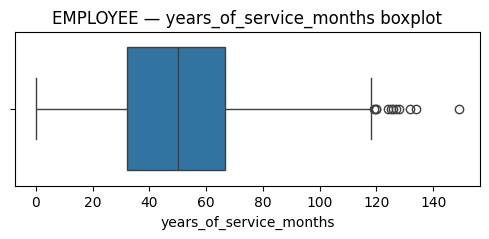

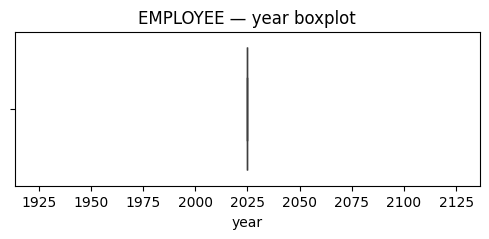

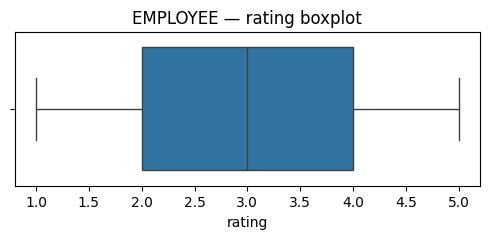

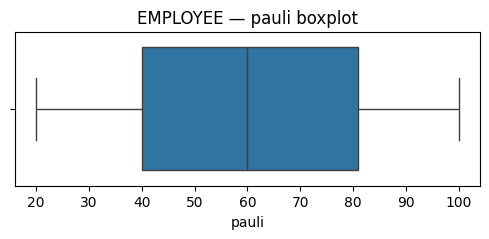

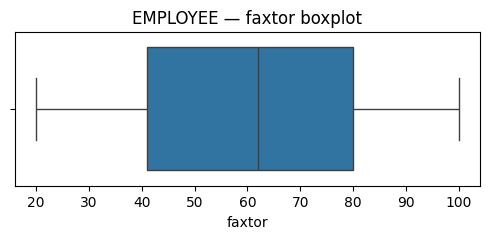

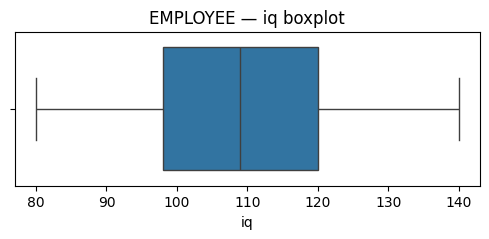

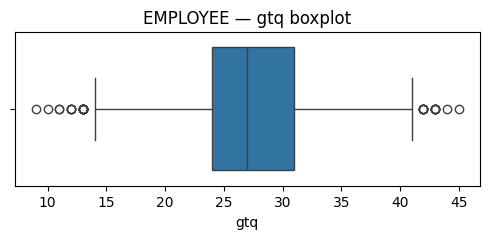

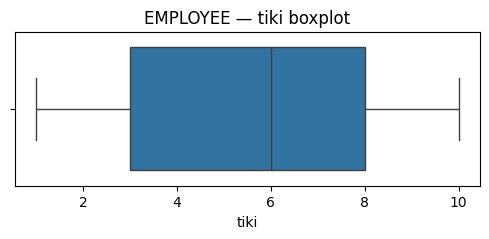

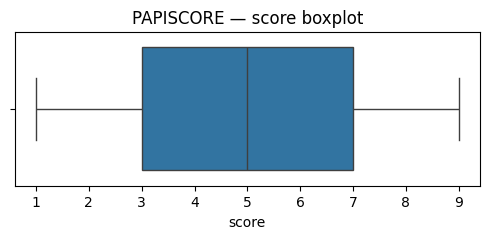

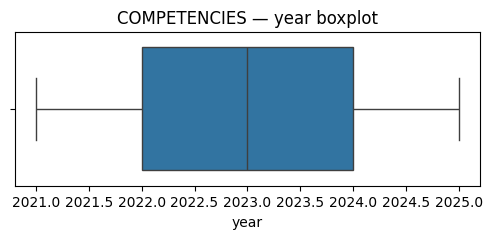

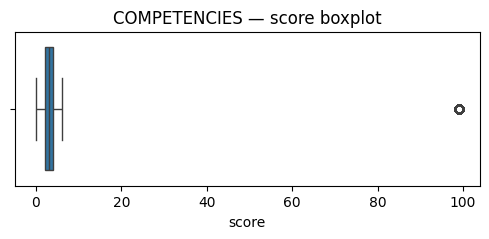

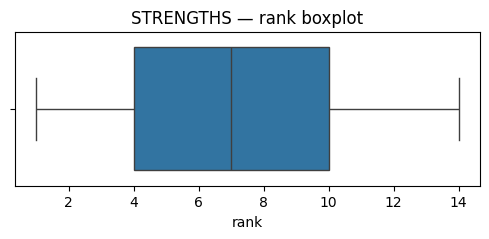

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

for name, df in datasets_imputed.items():
    numeric_cols = df.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        plt.figure(figsize=(6,2))
        sns.boxplot(x=df[col])
        plt.title(f"{name.upper()} — {col} boxplot")
        plt.show()

In [20]:
for name, df in datasets_imputed.items():
    print(f"\n{name.upper()} — numeric summary:")
    print(df.describe())


EMPLOYEE — numeric summary:
       years_of_service_months    year       rating        pauli       faxtor  \
count              1790.000000  1790.0  1790.000000  1790.000000  1790.000000   
mean                 50.325140  2025.0     3.093296    60.133520    60.365922   
std                  25.092214     0.0     1.085351    23.413185    22.785795   
min                   0.000000  2025.0     1.000000    20.000000    20.000000   
25%                  32.000000  2025.0     2.000000    40.000000    41.000000   
50%                  50.000000  2025.0     3.000000    60.000000    62.000000   
75%                  66.750000  2025.0     4.000000    81.000000    80.000000   
max                 149.000000  2025.0     5.000000   100.000000   100.000000   

                iq          gtq         tiki  
count  1790.000000  1790.000000  1790.000000  
mean    109.446927    27.362011     5.488827  
std      15.796400     5.744875     2.890326  
min      80.000000     9.000000     1.000000  
25%   

In [21]:
competencies_imputed.loc[~competencies_imputed['score'].between(1, 5), 'score'] = np.nan

competencies_imputed['score'] = competencies_imputed.groupby('pillar_code')['score'].transform(
    lambda x: x.fillna(x.median())
)

In [22]:
competencies_imputed['score'].describe()

count    89500.000000
mean         3.101151
std          1.095641
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: score, dtype: float64

# Data Preparation

In [23]:
for name, df in datasets_imputed.items():
    print(f"\n{name.upper()}")
    print(df.head())


EMPLOYEE
  employee_id                  fullname     nip  \
0   EMP100000            Rendra Pratama  806137   
1   EMP100001            Wulan Setiawan  476388   
2   EMP100002  Julia Jatmiko Situmorang  941921   
3   EMP100003                 Oka Halim  751615   
4   EMP100004               Dwi Pratama  443809   

                     company_name area_name     position_name department_name  \
0      PT Aurora Beauty Indonesia     Store   Brand Executive             R&D   
1  PT Mandala Distribution Center     Store              HRBP      Operations   
2      PT Aurora Beauty Indonesia     Plant  Sales Supervisor         Finance   
3      PT Aurora Beauty Indonesia     Plant              HRBP              HR   
4          PT Lumo Cosmetics Asia     Store    Supply Planner      Operations   

       division_name directorate_name grade_name  ...  year rating  pauli  \
0        Product Dev       Technology         IV  ...  2025      3   86.0   
1  Talent Management       Technology     

In [24]:
employee_df=datasets_imputed["employee"]
papi_df=datasets_imputed["papiscore"]
comp_df=datasets_imputed["competencies"]
strengths_df=datasets_imputed["strengths"]

In [25]:
mapping = pd.read_csv("Study Case DA - Talent Variable (TV) & Talent Group Variable (TGV).csv", encoding='latin1' )

mapping.head()

,Test as Talent Variable (TV),Sub-test,Meaning,Behavior Example,Talent Group Variable (TGV),Note
0,Pauli,Initial Performance,Measures starting accuracy/speed,"Quick starter shows immediate focus, slower st...",Motivation & Drive,NaN
1,MBTI,Extraversion,Energy from social interaction,"Talkative, networking",Leadership & Influence,NaN
2,MBTI,Introversion,Energy from solitude,"Reflective, prefers quiet",Leadership & Influence,NaN
3,MBTI,Sensing,"Detail, concrete focus","Practical, present-oriented",Conscientiousness & Reliability,NaN
4,MBTI,Intuition,"Pattern recognition, future focus","Big-picture, imaginative",Creativity & Innovation Orientation,NaN


In [26]:
def extract_mbti_features(df):

    df['mbti'] = df['mbti'].str.strip().str.upper()
    valid_mask = df['mbti'].str.len() == 4
    mbti = df.loc[valid_mask, 'mbti']

    mbti_cols = ['mbti_Extraversion', 'mbti_Introversion', 'mbti_Sensing', 'mbti_Intuition', 'mbti_Thinking',
                 'mbti_Feeling', 'mbti_Judging', 'mbti_Perceiving']

    for col in mbti_cols:
        df[col] = 0
    
    # Create 8 binary columns (E/I, S/N, T/F, J/P)
    df.loc[valid_mask, 'mbti_Extraversion'] = (mbti.str[0] == 'E').astype(int)
    df.loc[valid_mask, 'mbti_Introversion'] = (mbti.str[0] == 'I').astype(int)
    df.loc[valid_mask, 'mbti_Sensing'] = (mbti.str[1] == 'S').astype(int)
    df.loc[valid_mask, 'mbti_Intuition'] = (mbti.str[1] == 'N').astype(int)
    df.loc[valid_mask, 'mbti_Thinking'] = (mbti.str[2] == 'T').astype(int)
    df.loc[valid_mask, 'mbti_Feeling'] = (mbti.str[2] == 'F').astype(int)
    df.loc[valid_mask, 'mbti_Judging'] = (mbti.str[3] == 'J').astype(int)
    df.loc[valid_mask, 'mbti_Perceiving'] = (mbti.str[3] == 'P').astype(int)

    return df

In [27]:
# def extract_disc_features(df):

#     # Extract first and second character
#     char1 = df['disc'].str.strip().str.upper().str[0]
#     char2 = df['disc'].str.strip().str.upper().str[1]
    
#     # Create binary columns (presence in either position)
#     df['disc_Dominance'] = ((char1 == 'D') | (char2 == 'D')).astype(int)
#     df['disc_Influence'] = ((char1 == 'I') | (char2 == 'I')).astype(int)
#     df['disc_Steadiness'] = ((char1 == 'S') | (char2 == 'S')).astype(int)
#     df['disc_Compliance'] = ((char1 == 'C') | (char2 == 'C')).astype(int)

#     return df

def extract_disc_features(df):
    # Extract first and second character
    char1 = df['disc'].str.strip().str.upper().str[0]
    char2 = df['disc'].str.strip().str.upper().str[1]
    
    # Create binary columns for first position
    df['disc_Dominance_1'] = (char1 == 'D').astype(int)
    df['disc_Influence_1'] = (char1 == 'I').astype(int)
    df['disc_Steadiness_1'] = (char1 == 'S').astype(int)
    df['disc_Compliance_1'] = (char1 == 'C').astype(int)
    
    # Create binary columns for second position
    df['disc_Dominance_2'] = (char2 == 'D').astype(int)
    df['disc_Influence_2'] = (char2 == 'I').astype(int)
    df['disc_Steadiness_2'] = (char2 == 'S').astype(int)
    df['disc_Compliance_2'] = (char2 == 'C').astype(int)
    
    return df

In [28]:
def pivot_papi_scores(papi_df):
    
    papi_wide = papi_df.pivot(
        index='employee_id',
        columns='scale_code',
        values='score'
    ).reset_index()
    
    # print(f"  ✓ Pivoted PAPI: {papi_wide.shape[0]} employees, {papi_wide.shape[1]-1} scales")
    # print(f"  ✓ PAPI scales: {sorted([col for col in papi_wide.columns if col.startswith('Papi_')])}")
    
    return papi_wide

In [29]:
def create_strengths_binary(strengths_df):
    
    all_themes = strengths_df['theme'].dropna().unique()

    # Create binary presence (1 if theme exists in top 14, 0 otherwise)
    strengths_binary = strengths_df.groupby(['employee_id', 'theme']).size().reset_index(name='count')
    strengths_binary['has_strength'] = 1
    
    # Pivot to wide format
    strengths_wide = strengths_binary.pivot(
        index='employee_id',
        columns='theme',
        values='has_strength'
    ).fillna(0).astype(int).reset_index()
    
    # Add prefix 'strength_'
    strengths_wide.columns = ['employee_id'] + [f'strength_{col}' for col in strengths_wide.columns[1:]]
    
    return strengths_wide

In [30]:
def aggregate_competencies(comp_df):
    
    # Average score per employee per pillar (across years 2021-2025)
    comp_avg_pillar = comp_df.groupby(['employee_id', 'pillar_code'])['score'].mean().reset_index()
    
    # Pivot by pillar
    comp_wide = comp_avg_pillar.pivot(
        index='employee_id',
        columns='pillar_code',
        values='score'
    ).reset_index()
    
    comp_wide.columns = ['employee_id'] + [f'comp_{col}' for col in comp_wide.columns[1:]]
    
    # Overall competency average (across all pillars)
    comp_cols = [col for col in comp_wide.columns if col.startswith('comp_')]
    comp_wide['competency_avg'] = comp_wide[comp_cols].mean(axis=1)
    
    # print(f"  ✓ Aggregated competencies: {len(comp_cols)} pillars")
    # print(f"  ✓ Pillars: {[col.replace('comp_', '') for col in comp_cols]}")
    
    return comp_wide

In [31]:
def build_master_dataset(employee_df, papi_df, comp_df, strengths_df):
    print("\n" + "="*80)
    print("BUILDING MASTER DATASET")
    print("="*80)
    
    master = employee_df.copy()

    # Extract MBTI (8 columns)
    master = extract_mbti_features(master)
    # Extract DISC (4 columns)
    master = extract_disc_features(master)
    # Merge PAPI scores (20 columns)
    papi_wide = pivot_papi_scores(papi_df)
    master = master.merge(papi_wide, on='employee_id', how='left')
    # Merge Strengths (34 binary columns)
    strengths_wide = create_strengths_binary(strengths_df)
    master = master.merge(strengths_wide, on='employee_id', how='left')
    # Merge Competencies (10 pillars + avg)
    comp_wide = aggregate_competencies(comp_df)
    master = master.merge(comp_wide, on='employee_id', how='left')
    print(f"\n✓ After merging Competencies: {master.shape}")
    
    # Create high performer flag (rating == 5)
    master['is_high_performer'] = (master['rating'] == 5).astype(int)
    
    n_high = master['is_high_performer'].sum()
    n_total = len(master)
    print(f"\n High Performers (Rating 5): {n_high} / {n_total} ({n_high/n_total*100:.2f}%)")
    
    # Create tenure in years (if years_of_service_months exists)
    if 'years_of_service_months' in master.columns:
        master['tenure_years'] = master['years_of_service_months'] / 12
    
    print(f"\n FINAL MASTER DATASET: {master.shape}")
    print(f" Columns: {master.columns.tolist()}")
    
    return master

In [32]:
master = build_master_dataset(employee_df, papi_df, comp_df, strengths_df)


BUILDING MASTER DATASET

✓ After merging Competencies: (1790, 104)

 High Performers (Rating 5): 168 / 1790 (9.39%)

 FINAL MASTER DATASET: (1790, 106)
 Columns: ['employee_id', 'fullname', 'nip', 'company_name', 'area_name', 'position_name', 'department_name', 'division_name', 'directorate_name', 'grade_name', 'education_name', 'major_name', 'years_of_service_months', 'year', 'rating', 'pauli', 'faxtor', 'disc', 'disc_word', 'mbti', 'iq', 'gtq', 'tiki', 'mbti_Extraversion', 'mbti_Introversion', 'mbti_Sensing', 'mbti_Intuition', 'mbti_Thinking', 'mbti_Feeling', 'mbti_Judging', 'mbti_Perceiving', 'disc_Dominance_1', 'disc_Influence_1', 'disc_Steadiness_1', 'disc_Compliance_1', 'disc_Dominance_2', 'disc_Influence_2', 'disc_Steadiness_2', 'disc_Compliance_2', 'Papi_A', 'Papi_B', 'Papi_C', 'Papi_D', 'Papi_E', 'Papi_F', 'Papi_G', 'Papi_I', 'Papi_K', 'Papi_L', 'Papi_N', 'Papi_O', 'Papi_P', 'Papi_R', 'Papi_S', 'Papi_T', 'Papi_V', 'Papi_W', 'Papi_X', 'Papi_Z', 'strength_Achiever', 'strength_A

In [33]:
print(master.head())

  employee_id                  fullname     nip  \
0   EMP100000            Rendra Pratama  806137   
1   EMP100001            Wulan Setiawan  476388   
2   EMP100002  Julia Jatmiko Situmorang  941921   
3   EMP100003                 Oka Halim  751615   
4   EMP100004               Dwi Pratama  443809   

                     company_name area_name     position_name department_name  \
0      PT Aurora Beauty Indonesia     Store   Brand Executive             R&D   
1  PT Mandala Distribution Center     Store              HRBP      Operations   
2      PT Aurora Beauty Indonesia     Plant  Sales Supervisor         Finance   
3      PT Aurora Beauty Indonesia     Plant              HRBP              HR   
4          PT Lumo Cosmetics Asia     Store    Supply Planner      Operations   

       division_name directorate_name grade_name  ... comp_GDR comp_IDS  \
0        Product Dev       Technology         IV  ...      2.6      2.6   
1  Talent Management       Technology        III  ...   

In [34]:
null_count = master.isnull().sum()
null_percent = (master.isnull().mean() * 100).round(1)
summary = pd.DataFrame({
    "Null Count": null_count,
    "Null %": null_percent
})
print(summary[summary["Null Count"] > 0].sort_values("Null %", ascending=False))

        Null Count  Null %
Papi_A         124     6.9
Papi_B         124     6.9
Papi_X         124     6.9
Papi_W         124     6.9
Papi_V         124     6.9
Papi_T         124     6.9
Papi_S         124     6.9
Papi_R         124     6.9
Papi_P         124     6.9
Papi_O         124     6.9
Papi_N         124     6.9
Papi_L         124     6.9
Papi_K         124     6.9
Papi_I         124     6.9
Papi_G         124     6.9
Papi_F         124     6.9
Papi_E         124     6.9
Papi_D         124     6.9
Papi_C         124     6.9
Papi_Z         124     6.9


# Explatory Data Analysis

## High Performer Distribution

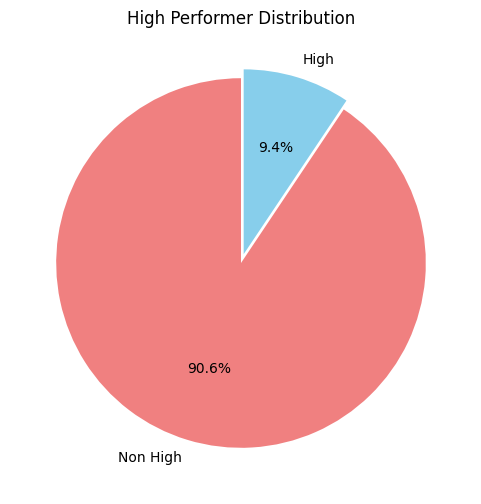

In [35]:
counts = master['is_high_performer'].value_counts()
labels = ['Non High', 'High']
colors = ['lightcoral', 'skyblue']

plt.figure(figsize=(6,6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, explode=(0,0.05))
plt.title("High Performer Distribution")
plt.show()

In [36]:
def add_value_labels(ax, spacing=0.5, fmt=int, orientation='v'):
    for p in ax.patches:
        if orientation == 'v':
            height = p.get_height()
            if height > 0:
                ax.text(
                    p.get_x() + p.get_width()/2., 
                    height + spacing, 
                    fmt(height),
                    ha='center', va='bottom', fontsize=10
                )
        elif orientation == 'h':
            width = p.get_width()
            if width > 0:
                ax.text(
                    width + spacing, 
                    p.get_y() + p.get_height()/2.,
                    fmt(width),
                    ha='left', va='center', fontsize=10
                )

C:\Users\ljhab\AppData\Local\Temp\ipykernel_4824\3727289014.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=sizes, palette=colors)


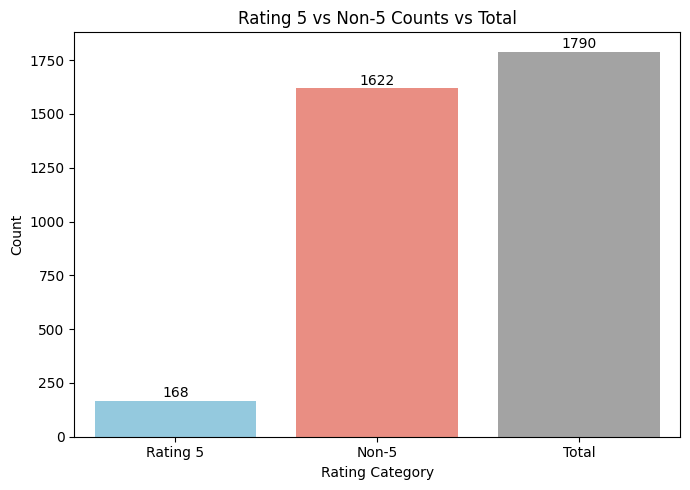

In [37]:
count_rating5 = (master['rating'] == 5).sum()
count_non5 = (master['rating'] != 5).sum()
count_total = len(master)

labels = ['Rating 5', 'Non-5', 'Total']
sizes = [count_rating5, count_non5, count_total]
colors = ['skyblue', 'salmon', '#a3a3a3']

plt.figure(figsize=(7,5))
ax = sns.barplot(x=labels, y=sizes, palette=colors)
plt.title("Rating 5 vs Non-5 Counts vs Total")
plt.ylabel("Count")
plt.xlabel("Rating Category")
add_value_labels(ax, fmt=int, orientation='v')
plt.tight_layout()
plt.show()


## Performance Rating Distribution

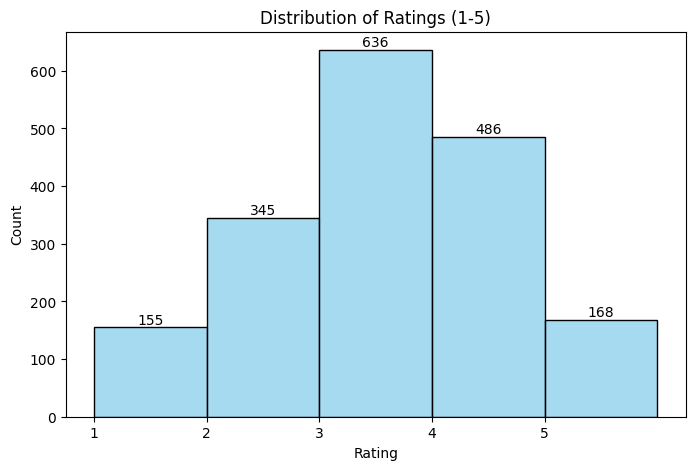

In [38]:
plt.figure(figsize=(8,5))
ax = sns.histplot(master['rating'], bins=[1,2,3,4,5,6], kde=False, color='skyblue', edgecolor='black')
plt.title("Distribution of Ratings (1-5)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks([1,2,3,4,5])
add_value_labels(ax, fmt=int, orientation='v')
plt.show()

## Top 20 Correlations with High Performer and Rating

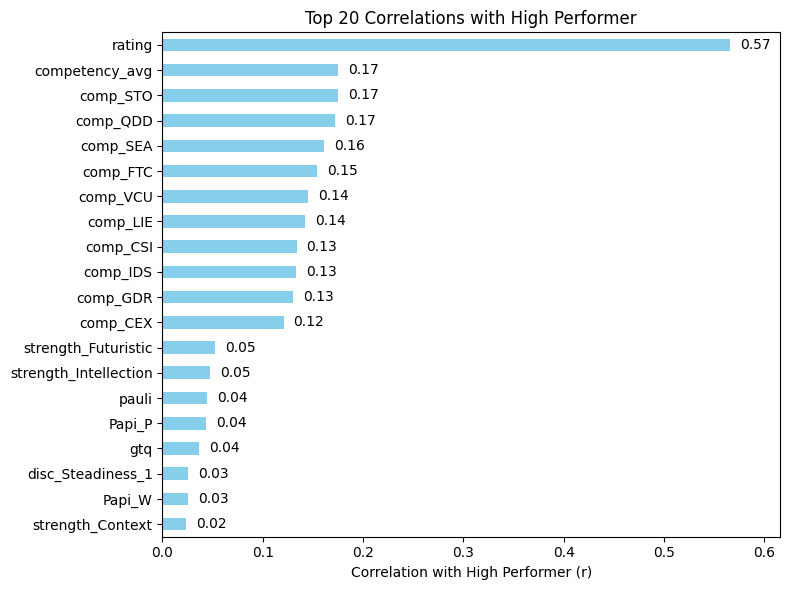

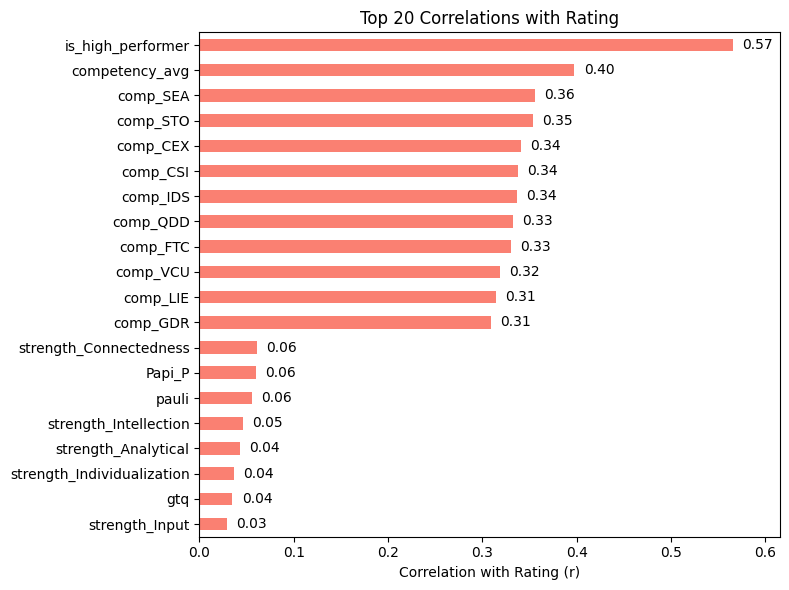

In [39]:
num_cols = master.select_dtypes(include=[np.number]).columns.tolist()

corr_perf = master[num_cols].corr()['is_high_performer'].drop('is_high_performer').sort_values(ascending=False)
top_corr_perf = corr_perf.head(20)

corr_rating = master[num_cols].corr()['rating'].drop('rating').sort_values(ascending=False)
top_corr_rating = corr_rating.head(20)

# High Performer
plt.figure(figsize=(8,6))
ax1 = top_corr_perf.sort_values().plot(kind='barh', color='skyblue')
plt.title("Top 20 Correlations with High Performer")
plt.xlabel("Correlation with High Performer (r)")
ax1.set_xlim(left=0, right=top_corr_perf.max() + 0.05)
add_value_labels(ax1, spacing=0.01, fmt=lambda x: f"{x:.2f}", orientation='h')
plt.tight_layout()
plt.show()

# Rating
plt.figure(figsize=(8,6))
ax2 = top_corr_rating.sort_values().plot(kind='barh', color='salmon')
plt.title("Top 20 Correlations with Rating")
plt.xlabel("Correlation with Rating (r)")
ax2.set_xlim(left=0, right=top_corr_rating.max() + 0.05)
add_value_labels(ax2, spacing=0.01, fmt=lambda x: f"{x:.2f}", orientation='h')
plt.tight_layout()
plt.show()

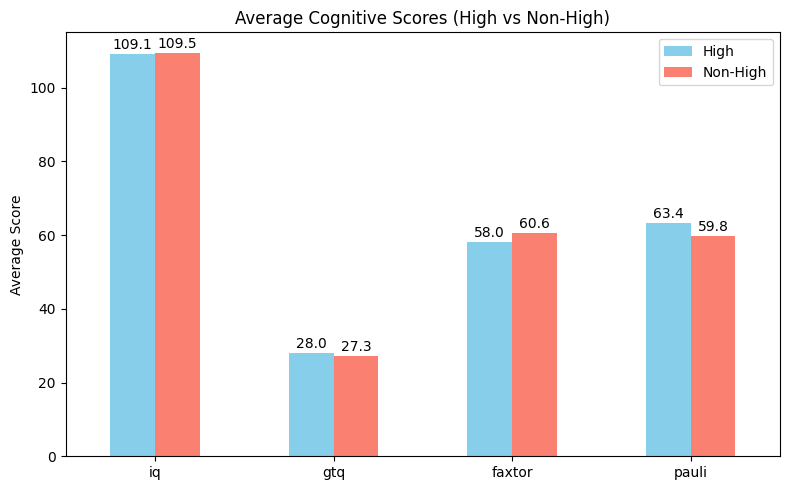

In [40]:
cog_cols = ['iq', 'gtq', 'faxtor', 'pauli']

cog_means = (master.groupby('is_high_performer')[cog_cols].mean().T)
cog_means.columns = ['Non-High', 'High'] if 0 in cog_means.columns else ['High', 'Non-High']

cog_means = cog_means[['High', 'Non-High']]
ax = cog_means.plot(kind='bar', figsize=(8,5), color=['skyblue','salmon'])
plt.title("Average Cognitive Scores (High vs Non-High)")
plt.ylabel("Average Score")
plt.xticks(rotation=0)
add_value_labels(ax, fmt=lambda x: f"{x:.1f}", orientation='v')
plt.tight_layout()
plt.show()

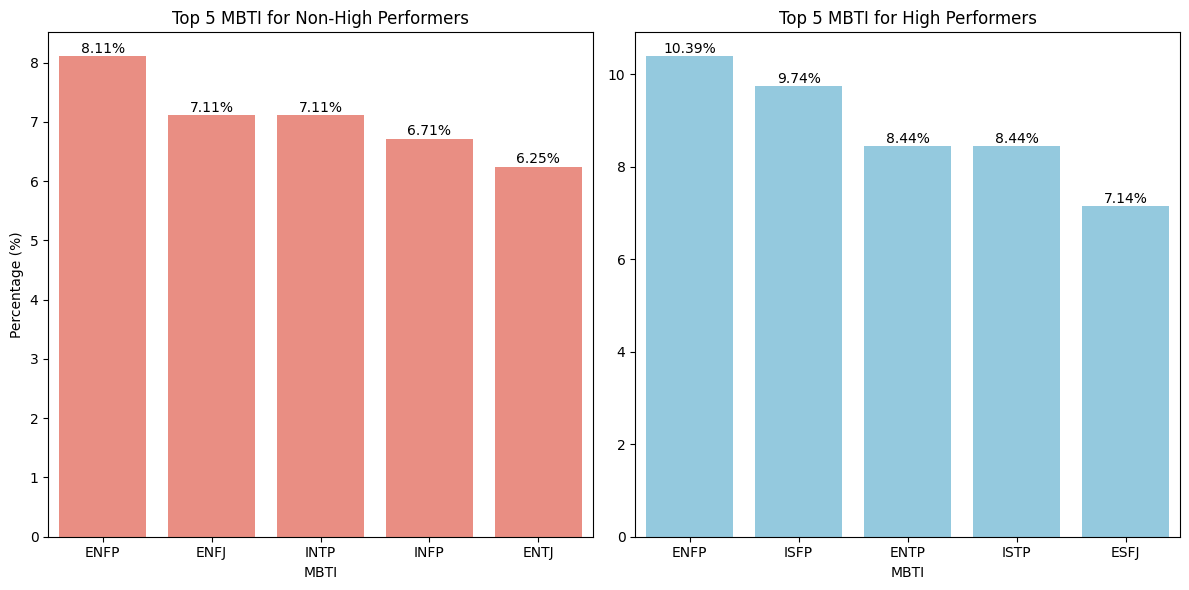

In [41]:
df_mbti = master[master['mbti'] != 'UNKNOWN'].copy()
mbti_counts = df_mbti.groupby('is_high_performer')['mbti'].value_counts(normalize=True) * 100

# Top 5 MBTI Non-High
top5_non_high = mbti_counts[0].nlargest(5)
# Top 5 MBTI High
top5_high = mbti_counts[1].nlargest(5)

fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Plot Non-High di subplot kiri
ax1 = sns.barplot(y=top5_non_high.values, x=top5_non_high.index, color='salmon', ax=axes[0])
axes[0].set_title("Top 5 MBTI for Non-High Performers")
axes[0].set_ylabel("Percentage (%)")
axes[0].set_xlabel("MBTI")
add_value_labels(ax1, spacing=0.01, fmt=lambda x: f"{x:.2f}%", orientation='v')

# Plot High di subplot kanan
ax2 = sns.barplot(y=top5_high.values, x=top5_high.index, color='skyblue', ax=axes[1])
axes[1].set_title("Top 5 MBTI for High Performers")
axes[1].set_ylabel("")
axes[1].set_xlabel("MBTI")
add_value_labels(ax2, spacing=0.01, fmt=lambda x: f"{x:.2f}%", orientation='v')

plt.tight_layout()
plt.show()

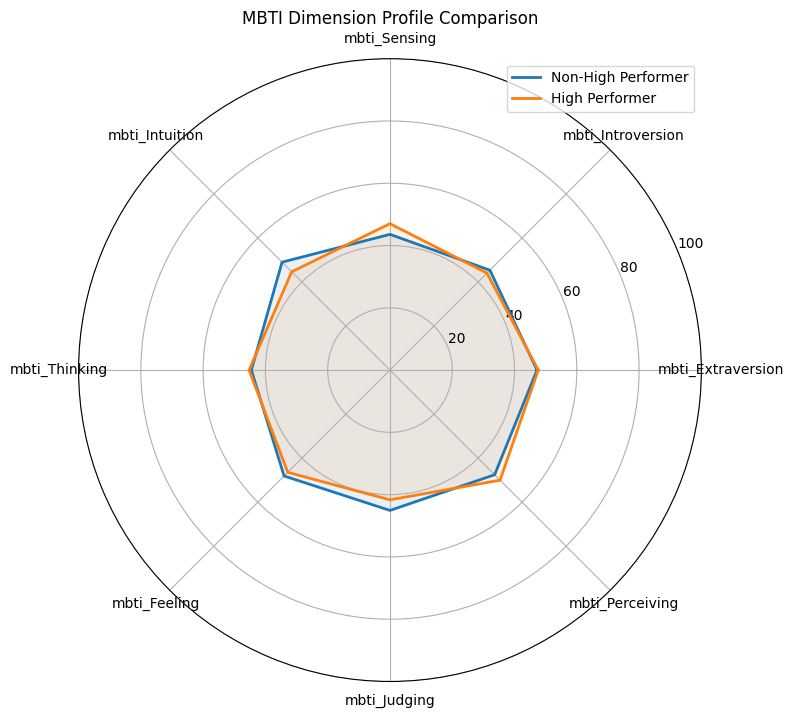

In [42]:
mbti_cols = [c for c in master.columns if c.startswith("mbti_")]

# Rata-rata per dimensi → representasi proporsi %
radar_data = master.groupby("is_high_performer")[mbti_cols].mean() * 100

labels = radar_data.columns
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Loop two groups: Non-High(0) & High(1)
for i, segment in enumerate(radar_data.index):
    values = radar_data.loc[segment].tolist()
    values += values[:1]
    
    ax.plot(angles, values, linewidth=2, label="High Performer" if segment==1 else "Non-High Performer")
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_ylim(0, 100)
plt.title("MBTI Dimension Profile Comparison")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

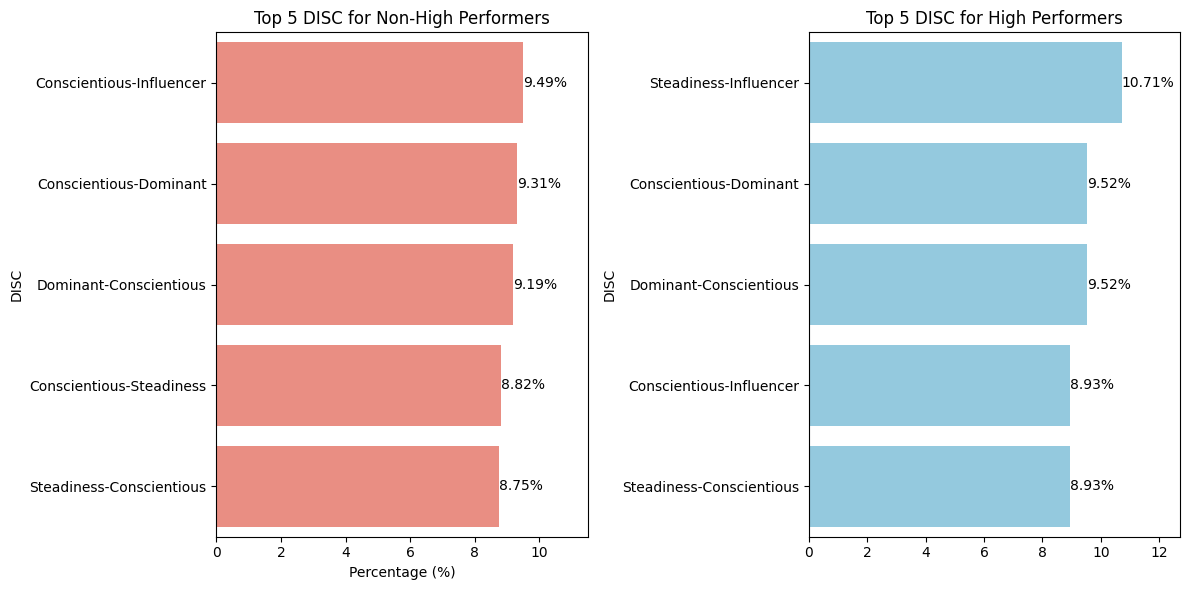

In [43]:
disc_counts = master.groupby('is_high_performer')['disc_word'].value_counts(normalize=True) * 100

# Top 5 MBTI Non-High
top5_non_high = disc_counts[0].nlargest(5)
# Top 5 MBTI High
top5_high = disc_counts[1].nlargest(5)

fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Plot Non-High di subplot kiri
ax1 = sns.barplot(x=top5_non_high.values, y=top5_non_high.index, color='salmon', ax=axes[0])
axes[0].set_title("Top 5 DISC for Non-High Performers")
axes[0].set_xlabel("Percentage (%)")
axes[0].set_ylabel("DISC")
ax1.set_xlim(left=0, right=top5_non_high.max() + 2)
add_value_labels(ax1, spacing=0.01, fmt=lambda x: f"{x:.2f}%", orientation='h')

# Plot High di subplot kanan
ax2 = sns.barplot(x=top5_high.values, y=top5_high.index, color='skyblue', ax=axes[1])
axes[1].set_title("Top 5 DISC for High Performers")
axes[1].set_xlabel("")
axes[1].set_ylabel("DISC")
ax2.set_xlim(left=0, right=top5_high.max() + 2)
add_value_labels(ax2, spacing=0.01, fmt=lambda x: f"{x:.2f}%", orientation='h')

plt.tight_layout()
plt.show()

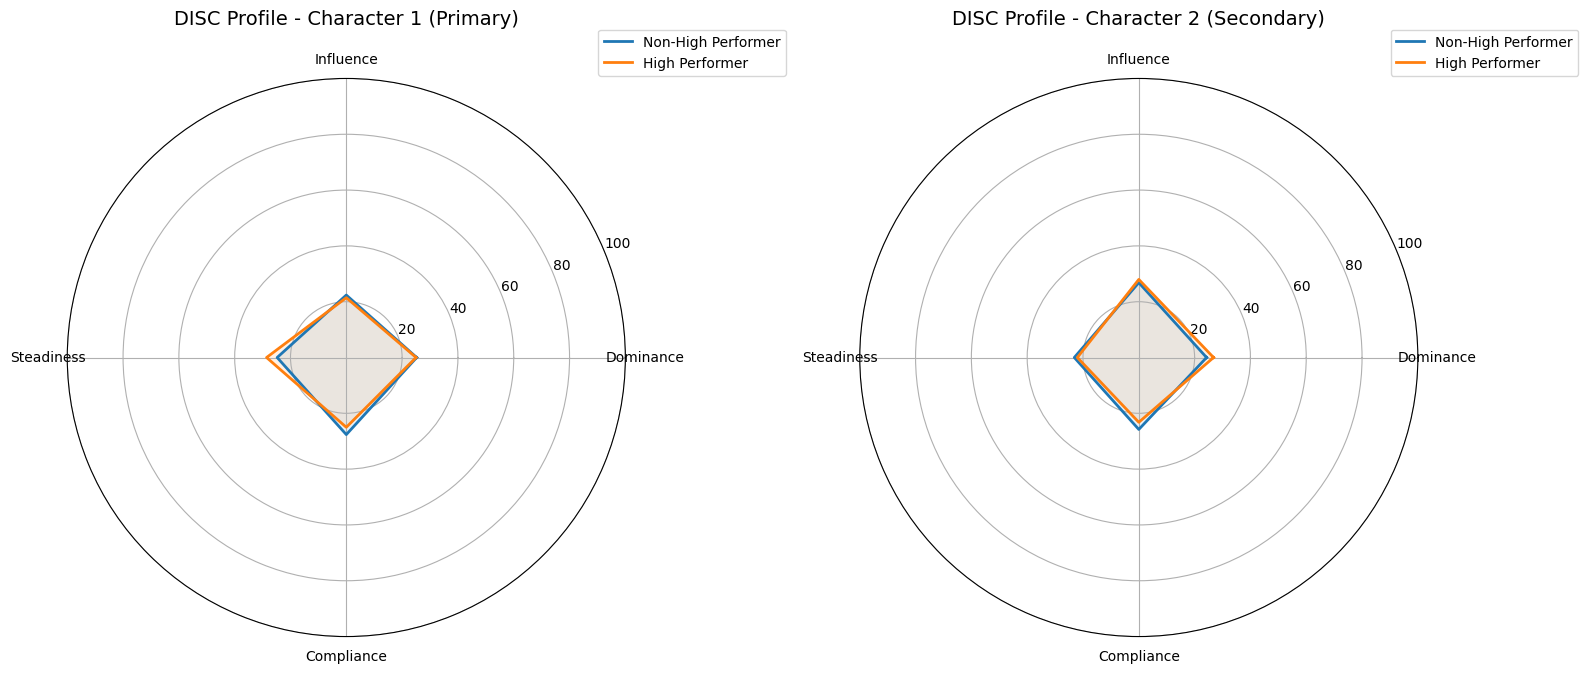

In [44]:
# disc_cols = [c for c in master.columns if c.startswith("disc_") and c not in ["disc_word"]]


# # Hitung rata-rata (%) per grup
# radar_disc = master.groupby("is_high_performer")[disc_cols].mean() * 100

# labels = radar_disc.columns
# angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
# angles += angles[:1]

# fig = plt.figure(figsize=(8, 8))
# ax = plt.subplot(111, polar=True)

# # Loop: 0 = Non-High, 1 = High Performer
# for segment in radar_disc.index:
#     values = radar_disc.loc[segment].tolist()
#     values += values[:1]

#     ax.plot(angles, values, linewidth=2,
#             label="High Performer" if segment == 1 else "Non-High Performer")
#     ax.fill(angles, values, alpha=0.1)

# ax.set_xticks(angles[:-1])
# ax.set_xticklabels(labels, fontsize=10)
# ax.set_ylim(0, 100)

# plt.title("DISC Behavior Profile Comparison", fontsize=14)
# plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.05))
# plt.tight_layout()
# plt.show()

disc_cols = [c for c in master.columns if c.startswith("disc_") and c not in ["disc_word"]]

# Pisahkan kolom untuk char1 dan char2
disc_cols_1 = [c for c in disc_cols if c.endswith("_1")]
disc_cols_2 = [c for c in disc_cols if c.endswith("_2")]

# Hitung rata-rata (%) per grup
radar_disc_1 = master.groupby("is_high_performer")[disc_cols_1].mean() * 100
radar_disc_2 = master.groupby("is_high_performer")[disc_cols_2].mean() * 100

# Buat labels (hapus suffix _1 dan _2 untuk tampilan)
labels_1 = [c.replace("disc_", "").replace("_1", "") for c in radar_disc_1.columns]
labels_2 = [c.replace("disc_", "").replace("_2", "") for c in radar_disc_2.columns]

# Setup angles
angles_1 = np.linspace(0, 2 * np.pi, len(labels_1), endpoint=False).tolist()
angles_1 += angles_1[:1]
angles_2 = np.linspace(0, 2 * np.pi, len(labels_2), endpoint=False).tolist()
angles_2 += angles_2[:1]

# Buat 2 subplot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), subplot_kw=dict(polar=True))

# Plot Char 1
for segment in radar_disc_1.index:
    values = radar_disc_1.loc[segment].tolist()
    values += values[:1]
    ax1.plot(angles_1, values, linewidth=2,
            label="High Performer" if segment == 1 else "Non-High Performer")
    ax1.fill(angles_1, values, alpha=0.1)

ax1.set_xticks(angles_1[:-1])
ax1.set_xticklabels(labels_1, fontsize=10)
ax1.set_ylim(0, 100)
ax1.set_title("DISC Profile - Character 1 (Primary)", fontsize=14, pad=20)
ax1.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

# Plot Char 2
for segment in radar_disc_2.index:
    values = radar_disc_2.loc[segment].tolist()
    values += values[:1]
    ax2.plot(angles_2, values, linewidth=2,
            label="High Performer" if segment == 1 else "Non-High Performer")
    ax2.fill(angles_2, values, alpha=0.1)

ax2.set_xticks(angles_2[:-1])
ax2.set_xticklabels(labels_2, fontsize=10)
ax2.set_ylim(0, 100)
ax2.set_title("DISC Profile - Character 2 (Secondary)", fontsize=14, pad=20)
ax2.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

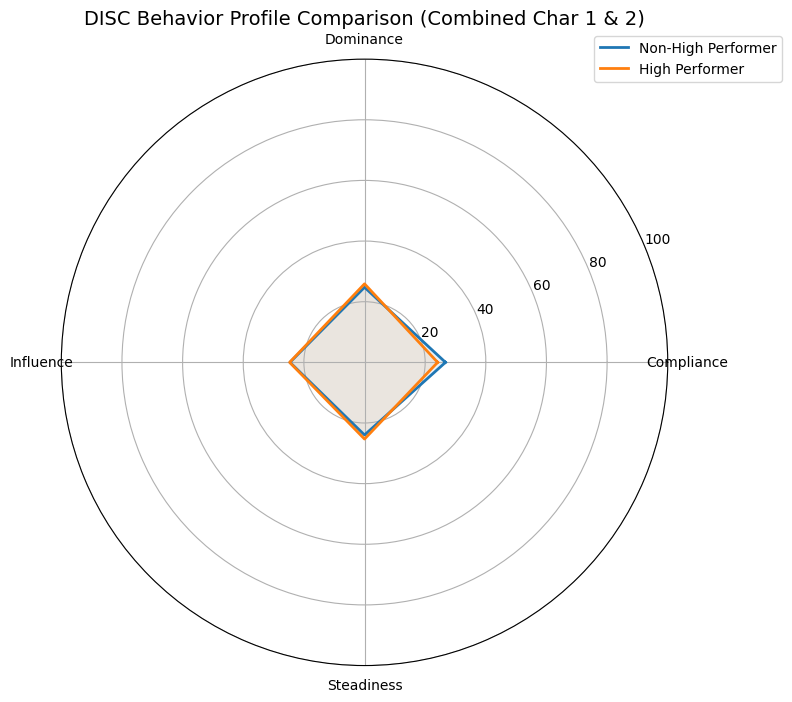

In [45]:
base_cols = sorted(list(set([c.replace("_1", "").replace("_2", "") for c in disc_cols])))

# Gabungkan nilai _1 dan _2 jadi satu kolom rata-rata
for base in base_cols:
    cols = [c for c in master.columns if c.startswith(base)]
    master[base] = master[cols].mean(axis=1)  # pakai .sum(axis=1) kalau mau total

# Hitung rata-rata (%) per grup High vs Non-High Performer
radar_disc = master.groupby("is_high_performer")[base_cols].mean() * 100

# Siapkan label & sudut untuk radar
labels = [c.replace("disc_", "") for c in base_cols]
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

# Plot radar chart
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

for segment in radar_disc.index:
    values = radar_disc.loc[segment].tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2,
            label="High Performer" if segment == 1 else "Non-High Performer")
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_ylim(0, 100)
plt.title("DISC Behavior Profile Comparison (Combined Char 1 & 2)", fontsize=14)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.05))
plt.tight_layout()
plt.show()

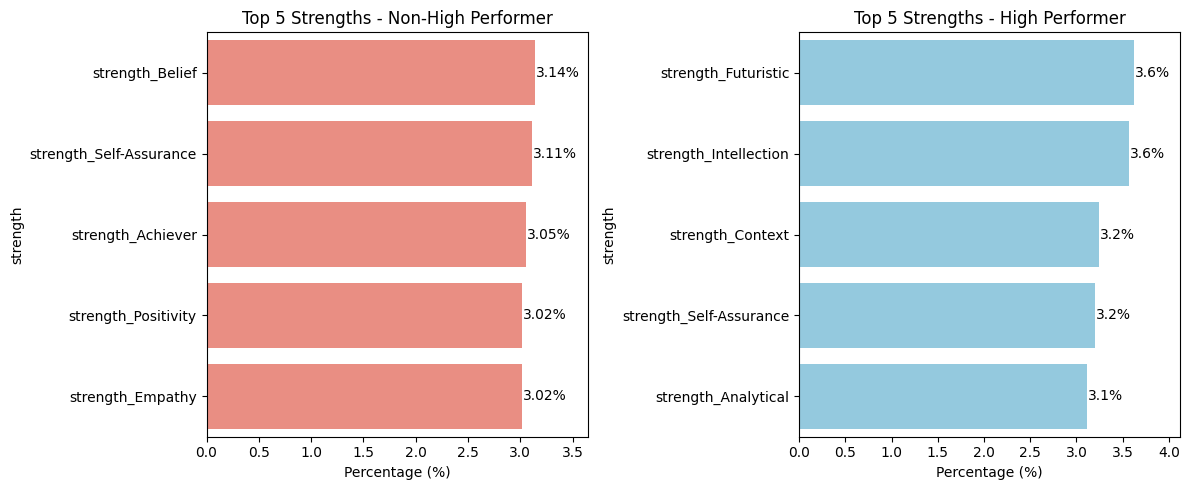

In [46]:
strength_cols = [c for c in master.columns if c.startswith('strength_')]

# Convert to long format untuk menghitung frekuensi
strength_long = master.melt(id_vars=['employee_id','is_high_performer'],
                             value_vars=strength_cols,
                             var_name='strength', value_name='has_strength')

strength_long = strength_long[strength_long['has_strength'] > 0]

# Hitung count per strength dan per grup
strength_count = (strength_long.groupby(['is_high_performer','strength'])
                  .size().reset_index(name='count'))

# Hitung total per grup
total_per_group = strength_count.groupby('is_high_performer')['count'].transform('sum')

# Tambahkan kolom persentase dengan transform (tanpa error)
strength_count['percentage'] = (strength_count['count'] / total_per_group) * 100

# Top 5 per grup berdasarkan persentase
top5_high = (strength_count.query('is_high_performer==1')
             .sort_values('percentage', ascending=False).head(5))
top5_non  = (strength_count.query('is_high_performer==0')
             .sort_values('percentage', ascending=False).head(5))

fig, axes = plt.subplots(1,2, figsize=(12,5))

# High Performer
ax1 = sns.barplot(data=top5_high, y='strength', x='percentage',
                  ax=axes[1], color='skyblue')
axes[1].set_title("Top 5 Strengths - High Performer")
axes[1].set_xlabel("Percentage (%)")
ax1.set_xlim(0, top5_high['percentage'].max() + 0.5)
add_value_labels(ax1, spacing=0.01, fmt=lambda x: f"{x:.1f}%", orientation='h')

# Non-High Performer
ax2 = sns.barplot(data=top5_non, y='strength', x='percentage',
                  ax=axes[0], color='salmon')
axes[0].set_title("Top 5 Strengths - Non-High Performer")
axes[0].set_xlabel("Percentage (%)")
ax2.set_xlim(0, top5_non['percentage'].max() + 0.5)
add_value_labels(ax2, spacing=0.01, fmt=lambda x: f"{x:.2f}%", orientation='h')

plt.tight_layout()
plt.show()

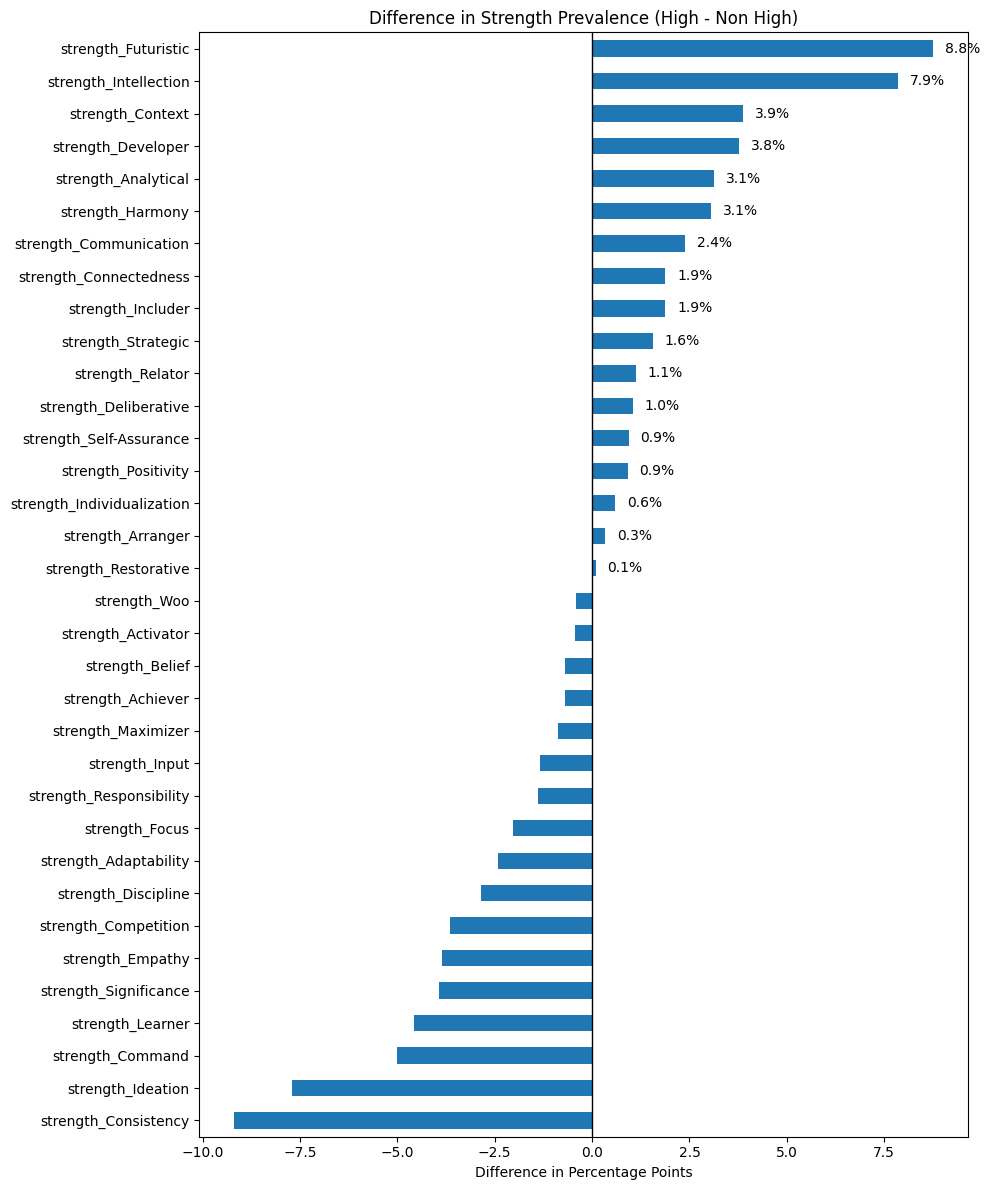

In [47]:
strength_mean = master.groupby('is_high_performer')[strength_cols].mean() * 100
diff = (strength_mean.loc[1] - strength_mean.loc[0]).sort_values(ascending=True)

plt.figure(figsize=(10,12))
ax = diff.plot(kind='barh')
plt.title("Difference in Strength Prevalence (High - Non High)")
plt.xlabel("Difference in Percentage Points")
add_value_labels(ax, spacing=0.3, fmt=lambda x: f"{x:.1f}%", orientation='h')
plt.axvline(0, color='black', linewidth=1)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


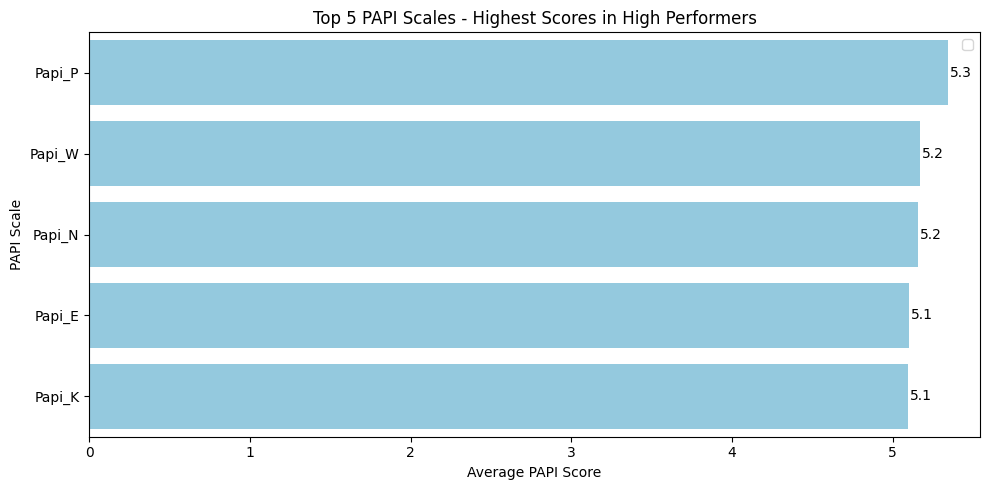

In [48]:
papi_cols = [c for c in master.columns if c.startswith('Papi_')]

papi_means = master.groupby('is_high_performer')[papi_cols].mean().T
papi_means.columns = ['Non-High', 'High']

top5_high = papi_means.sort_values('High', ascending=False).head(5)

plt.figure(figsize=(10,5))
ax = sns.barplot(
    y=top5_high.index,
    x=top5_high['High'],
    color='skyblue'
)

ax.set_xlim(left=0, right=top5_high['High'].max() + 0.2)
add_value_labels(ax, spacing=0.01, fmt=lambda x: f"{x:.1f}", orientation='h')

plt.title("Top 5 PAPI Scales - Highest Scores in High Performers")
plt.xlabel("Average PAPI Score")
plt.ylabel("PAPI Scale")
plt.legend()
plt.tight_layout()
plt.show()

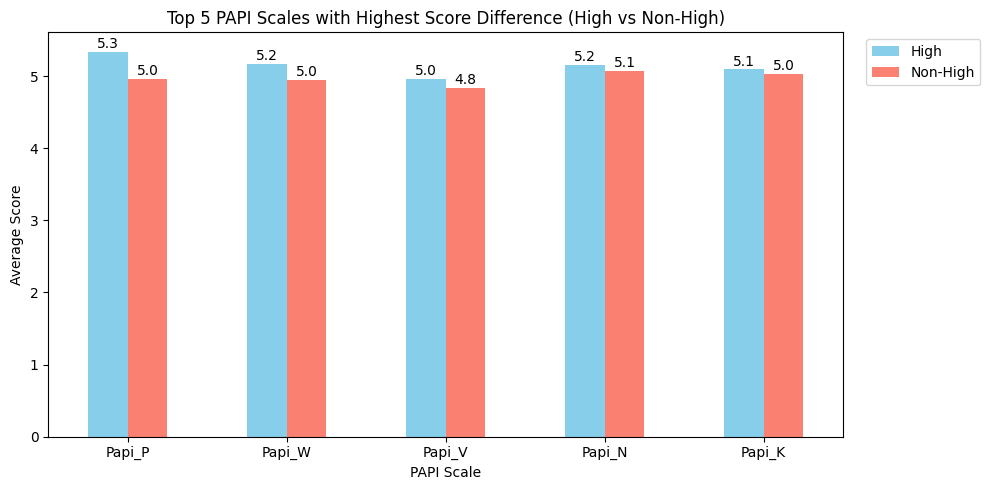

In [49]:
# Hitung selisih
papi_means['diff'] = papi_means['High'] - papi_means['Non-High']

# Urutkan berdasarkan selisih tertinggi, ambil top 5
papi_top5 = papi_means.sort_values('diff', ascending=False).head(5)

# Plot bar chart
ax = papi_top5[['High', 'Non-High']].plot(
    kind='bar',
    figsize=(10,5),
    color=['skyblue', 'salmon']
)

plt.title("Top 5 PAPI Scales with Highest Score Difference (High vs Non-High)")
plt.ylabel("Average Score")
plt.xlabel("PAPI Scale")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=True)
add_value_labels(ax, spacing=0.01, fmt=lambda x: f"{x:.1f}", orientation='v')
plt.tight_layout()
plt.show()

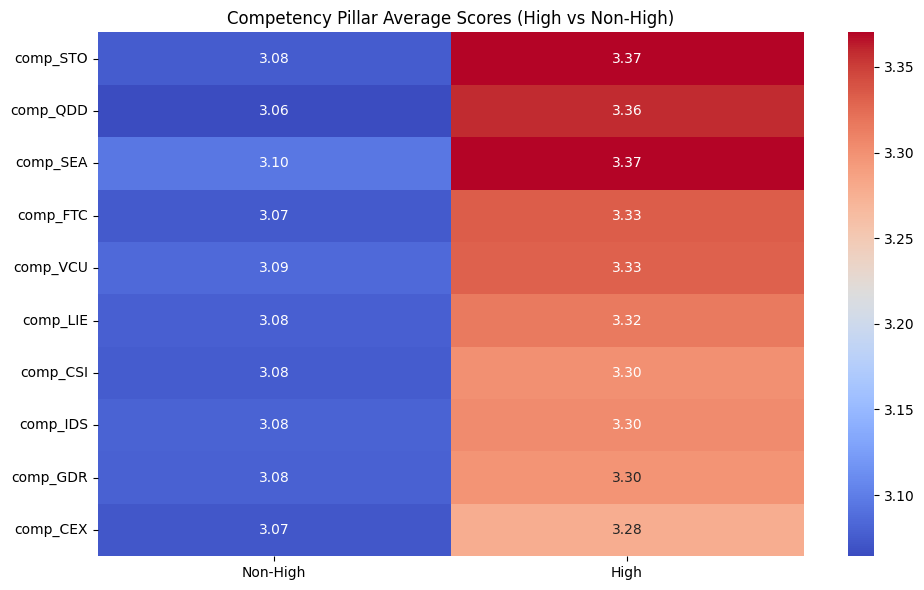

In [50]:
comp_cols = [c for c in master.columns if c.startswith('comp_') and c not in ['competency_avg']]
comp_means = master.groupby('is_high_performer')[comp_cols].mean().T
comp_means.columns = ['Non-High','High']
comp_means['diff'] = comp_means['High'] - comp_means['Non-High']
comp_means.sort_values('diff', ascending=False, inplace=True)

plt.figure(figsize=(10,6))
sns.heatmap(comp_means[['Non-High','High']], annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Competency Pillar Average Scores (High vs Non-High)")
plt.tight_layout()
plt.show()

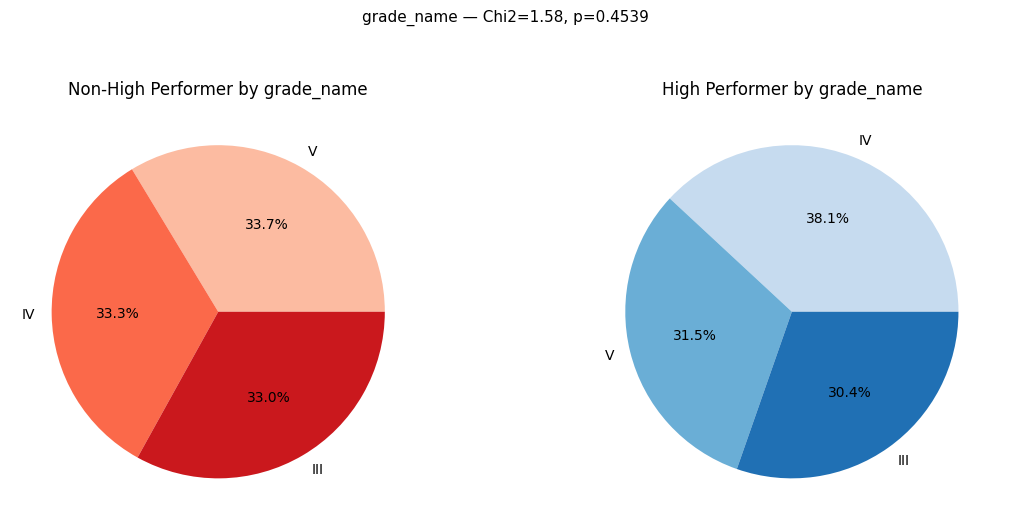

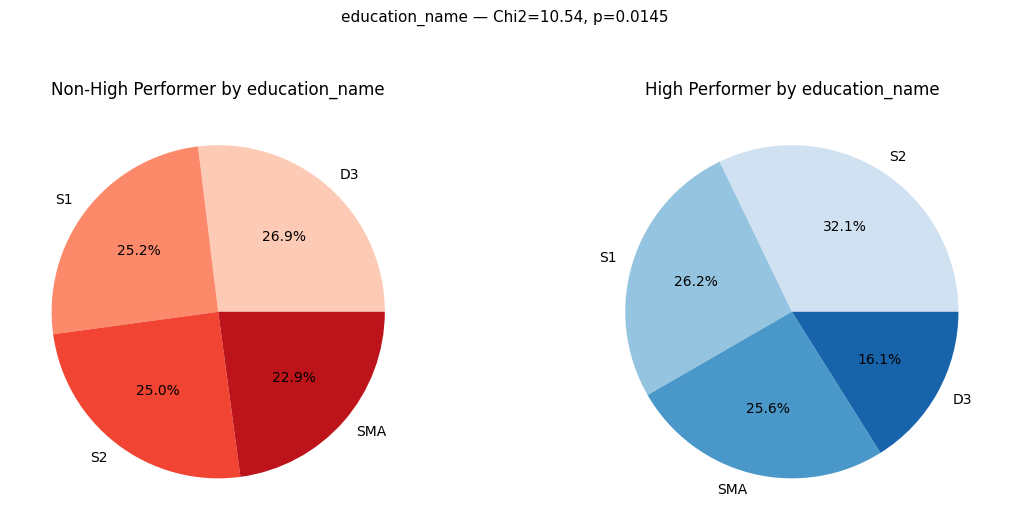

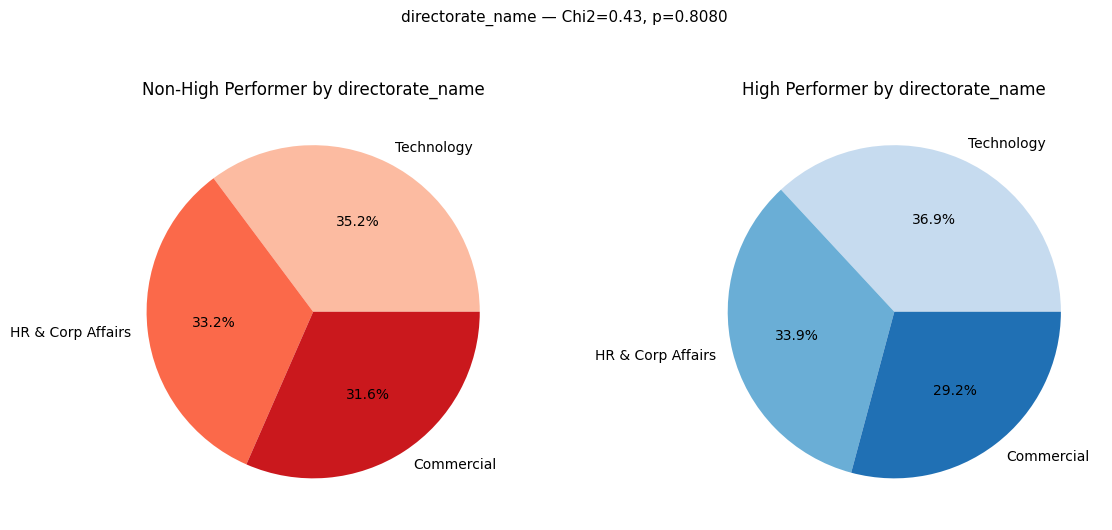

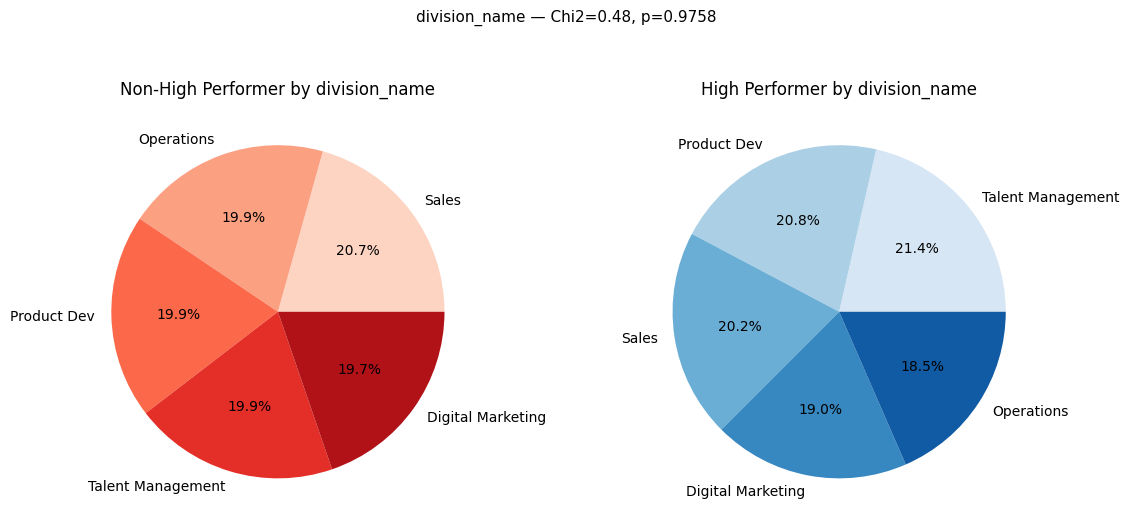

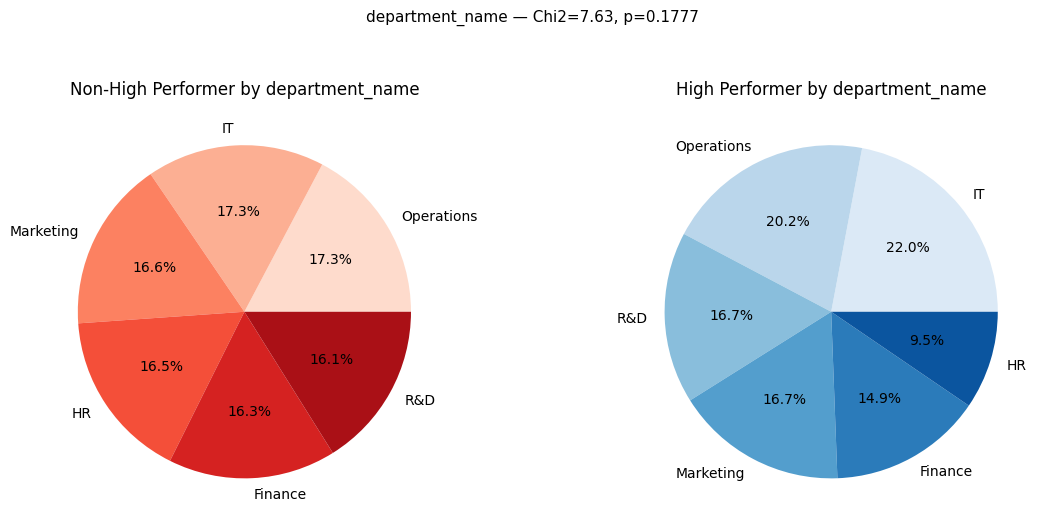

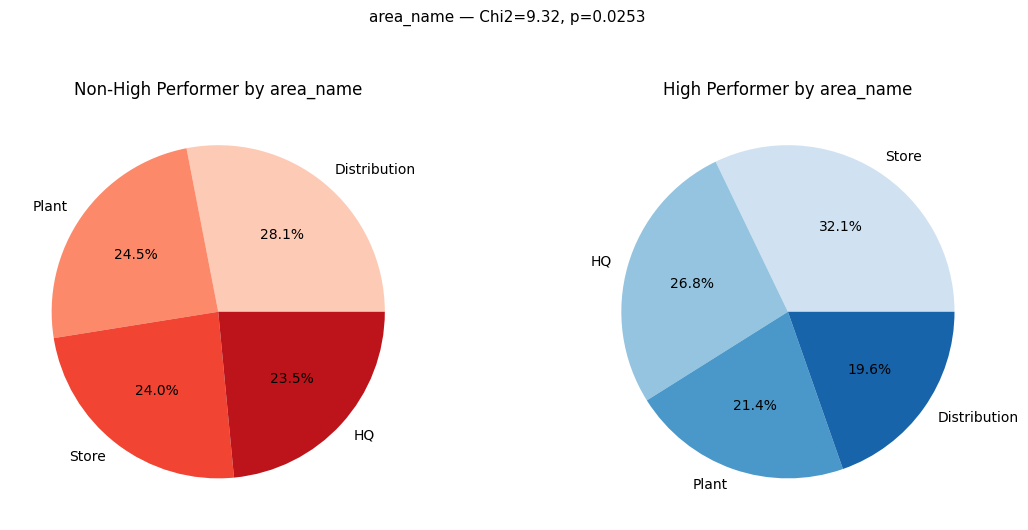

,Feature,Chi2,p-value,Significant
0,grade_name,1.579695,0.453914,No
1,education_name,10.539919,0.014493,Yes
2,directorate_name,0.426495,0.807956,No
3,division_name,0.475719,0.975821,No
4,department_name,7.632508,0.177686,No
5,area_name,9.323716,0.025283,Yes


In [52]:
from scipy.stats import chi2_contingency

contextual_cols = ['grade_name', 'education_name', 'directorate_name', 'division_name','department_name','area_name']

results = []  # buat simpan hasil uji Chi-Square

for col in contextual_cols:
    # Hapus kategori kosong
    df_col = master.dropna(subset=[col]).copy()
    
    # Buat tabel kontingensi High vs Non-High
    contingency = pd.crosstab(df_col[col], df_col['is_high_performer'])
    
    # Lakukan uji Chi-Square
    chi2, p, dof, expected = chi2_contingency(contingency)
    results.append({
        'Feature': col,
        'Chi2': chi2,
        'p-value': p,
        'Significant': 'Yes' if p < 0.05 else 'No'
    })
    
    # Visualisasi pie chart
    counts_non_high = df_col[df_col['is_high_performer']==0][col].value_counts()
    counts_high     = df_col[df_col['is_high_performer']==1][col].value_counts()
    
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    
    axes[0].pie(counts_non_high.values, labels=counts_non_high.index, autopct='%1.1f%%',
                colors=sns.color_palette("Reds", n_colors=len(counts_non_high)))
    axes[0].set_title(f"Non-High Performer by {col}")
    
    axes[1].pie(counts_high.values, labels=counts_high.index, autopct='%1.1f%%',
                colors=sns.color_palette("Blues", n_colors=len(counts_high)))
    axes[1].set_title(f"High Performer by {col}")
    
    plt.suptitle(f"{col} — Chi2={chi2:.2f}, p={p:.4f}", fontsize=11, y=1.05)
    plt.tight_layout()
    plt.show()

# Tampilkan hasil ringkasan uji Chi-Square
chi_results = pd.DataFrame(results)
display(chi_results)


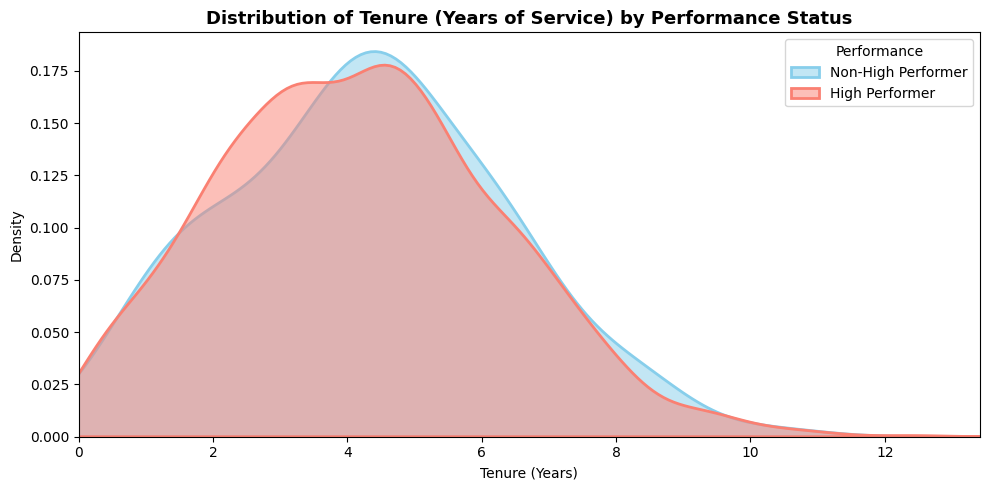

In [53]:
plt.figure(figsize=(10,5))

sns.kdeplot(
    data=master,
    x='tenure_years',
    hue='is_high_performer',
    fill=True,
    common_norm=False,
    palette={0:'salmon',1:'skyblue'}, 
    alpha=0.5,
    linewidth=2
)

plt.title("Distribution of Tenure (Years of Service) by Performance Status", fontsize=13, fontweight='bold')
plt.xlabel("Tenure (Years)")
plt.ylabel("Density")
plt.xlim(0, master['tenure_years'].max() + 1)
plt.legend(title="Performance", labels=["Non-High Performer","High Performer"])
plt.tight_layout()
plt.show()

# Succes Formula

In [54]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from scipy import stats



def define_variable_groups(master):

    numeric_cols = (
        ['pauli', 'faxtor', 'iq', 'gtq', 'tiki', 'years_of_service_months'] +
        [c for c in master.columns if c.startswith(('papi_', 'comp_'))]
    )
    
    
    binary_cols = [
        c for c in master.columns 
        if (
            (c.startswith('disc_') and c != 'disc_word')
            or c.startswith('strength_')
            or c.startswith('mbti_')
        )
    ]
    
    
    categorical_cols = ['grade_name', 'education_name', 'directorate_name', 'division_name','department_name','area_name']

    return numeric_cols, binary_cols, categorical_cols

def analyze_numeric_features(master, numeric_cols, target='is_high_performer'):
    """
    Point-Biserial Correlation for numeric variables
    """
    results = []
    
    for col in numeric_cols:
        if master[col].notna().sum() < 30:  # Skip if too many missing
            continue
            
        # Fill missing with median
        values = master[col].fillna(master[col].median())
        
        # Point-biserial correlation
        corr, pval = stats.pointbiserialr(master[target], values)
        
        # Mean comparison
        high_mean = master[master[target]==1][col].mean()
        low_mean = master[master[target]==0][col].mean()
        diff = high_mean - low_mean
        
        # Effect size (Cohen's d)
        pooled_std = np.sqrt(((master[master[target]==1][col].std()**2 + 
                               master[master[target]==0][col].std()**2) / 2))
        cohens_d = diff / pooled_std if pooled_std > 0 else 0
        
        results.append({
            'feature': col,
            'correlation': corr,
            'abs_correlation': abs(corr),
            'p_value': pval,
            'significant': pval < 0.05,
            'high_performer_mean': high_mean,
            'other_mean': low_mean,
            'mean_diff': diff,
            'cohens_d': cohens_d,
            'effect_size': 'Large' if abs(cohens_d) > 0.8 else ('Medium' if abs(cohens_d) > 0.5 else 'Small')
        })
    
    return pd.DataFrame(results).sort_values('abs_correlation', ascending=False)


def analyze_binary_features(master, binary_cols, target='is_high_performer'):
    """
    Chi-Square test for binary variables
    """
    results = []
    
    for col in binary_cols:
        if master[col].notna().sum() < 30:
            continue
        
        # Fill missing with 0
        values = master[col].fillna(0)
        
        # Chi-square test
        contingency = pd.crosstab(master[target], values)
        if contingency.shape == (2, 2):  # Only for 2x2 tables
            chi2, pval, dof, expected = stats.chi2_contingency(contingency)
            
            # Calculate prevalence
            high_prevalence = master[master[target]==1][col].mean()
            low_prevalence = master[master[target]==0][col].mean()
            
            # Odds ratio
            a, b = contingency.iloc[1, 1], contingency.iloc[1, 0]
            c, d = contingency.iloc[0, 1], contingency.iloc[0, 0]
            odds_ratio = (a * d) / (b * c) if (b * c) > 0 else np.nan
            
            results.append({
                'feature': col,
                'chi2': chi2,
                'p_value': pval,
                'significant': pval < 0.05,
                'high_performer_prevalence': high_prevalence,
                'other_prevalence': low_prevalence,
                'prevalence_diff': high_prevalence - low_prevalence,
                'odds_ratio': odds_ratio
            })
    
    return pd.DataFrame(results).sort_values('chi2', ascending=False)


def analyze_categorical_features(master, categorical_cols, target='is_high_performer'):
    """
    Chi-Square test for categorical variables
    """
    results = []
    
    for col in categorical_cols:
        if master[col].notna().sum() < 30:
            continue
        
        # Chi-square test
        contingency = pd.crosstab(master[target], master[col])
        chi2, pval, dof, expected = stats.chi2_contingency(contingency)
        
        # Cramer's V (effect size for chi-square)
        n = contingency.sum().sum()
        cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape) - 1)))
        
        results.append({
            'feature': col,
            'chi2': chi2,
            'p_value': pval,
            'significant': pval < 0.05,
            'cramers_v': cramers_v
        })
    
    return pd.DataFrame(results).sort_values('chi2', ascending=False)


# ============================================================================
# STEP 3: MACHINE LEARNING - RANDOM FOREST FEATURE IMPORTANCE
# ============================================================================

def ml_feature_importance(master, numeric_cols, binary_cols, categorical_cols=None, target='is_high_performer'):
    """
    Random Forest feature importance
    """
    # Prepare features
    X = master[numeric_cols + binary_cols].copy()

    if categorical_cols:
        cat_df = master[categorical_cols].copy()
        for col in categorical_cols:
            le = LabelEncoder()
            cat_df[col] = le.fit_transform(cat_df[col].astype(str))
        X = pd.concat([X, cat_df], axis=1)
    
    # Handle missing values
    for col in X.columns:
        if X[col].dtype in ['float64', 'int64']:
            X[col] = X[col].fillna(X[col].median())
        else:
            X[col] = X[col].fillna(0)
    
    y = master[target]
    
    # Fill missing values
    for col in X.columns:
        if X[col].dtype in ['float64', 'int64']:
            X[col] = X[col].fillna(X[col].median())
        else:
            X[col] = X[col].fillna(0)
    
    y = master[target]
    
    # Train Random Forest with cross-validation
    rf = RandomForestClassifier(
        n_estimators=200, 
        max_depth=10, 
        min_samples_split=20,
        random_state=42, 
        class_weight='balanced',
        n_jobs=-1
    )
    
    # Cross-validation score
    cv_scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
    print(f"📈 Random Forest CV ROC-AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")
    
    # Fit model
    rf.fit(X, y)
    
    # Feature importance
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'rf_importance': rf.feature_importances_
    }).sort_values('rf_importance', ascending=False)
    
    return importance_df, rf


# ============================================================================
# STEP 4: COMBINE METHODS & SELECT TOP FEATURES
# ============================================================================

def combine_feature_scores(numeric_results, binary_results, rf_importance, categorical_results=None):
    """
    Combine statistical and ML-based feature importance
    """
    # Normalize scores to 0-1
    def normalize(series):
        return (series - series.min()) / (series.max() - series.min())
    
    # Start with RF importance
    combined = rf_importance.copy()
    combined['rf_score'] = normalize(combined['rf_importance'])
    
    # Add statistical scores
    combined['stat_score'] = 0.0
    combined['significant'] = False
    
    for idx, row in combined.iterrows():
        feat = row['feature']
        
        # Check numeric results
        if feat in numeric_results['feature'].values:
            stat_row = numeric_results[numeric_results['feature'] == feat].iloc[0]
            combined.loc[idx, 'stat_score'] = normalize(
                numeric_results['abs_correlation']
            ).loc[numeric_results['feature'] == feat].values[0]
            combined.loc[idx, 'significant'] = stat_row['significant']
        
        # Check binary results
        elif feat in binary_results['feature'].values:
            stat_row = binary_results[binary_results['feature'] == feat].iloc[0]
            combined.loc[idx, 'stat_score'] = normalize(
                binary_results['chi2']
            ).loc[binary_results['feature'] == feat].values[0]
            combined.loc[idx, 'significant'] = stat_row['significant']

        elif categorical_results is not None and feat in categorical_results['feature'].values:
            stat_row = categorical_results[categorical_results['feature'] == feat].iloc[0]
            combined.loc[idx, 'stat_score'] = normalize(
                categorical_results['chi2']
            ).loc[categorical_results['feature'] == feat].values[0]
            combined.loc[idx, 'significant'] = stat_row['significant']
    
    # Final combined score (weighted average)
    combined['final_score'] = (0.6 * combined['rf_score'] + 
                               0.4 * combined['stat_score'])
    
    # Sort by final score
    combined = combined.sort_values('final_score', ascending=False)
    
    return combined


def select_top_features(combined_scores):
    """
    Select only statistically significant features (adaptive)
    If none are significant, fallback to top 15 by final score.
    """
    # Ambil hanya fitur signifikan
    significant_features = combined_scores[combined_scores['significant'] == True]

    if len(significant_features) > 0:
        top_features = significant_features.sort_values('final_score', ascending=False)
        print(f"\n🎯 SELECTED {len(top_features)} SIGNIFICANT FEATURES")
    else:
        # fallback jika tidak ada yang signifikan
        top_features = combined_scores.sort_values('final_score', ascending=False).head(15)
        print("\n⚠️ No significant features found — fallback to top 15 by score.")

    print(f"   Average final score: {top_features['final_score'].mean():.3f}")
    print(f"   top features:\n{top_features['feature'].tolist()}")

    return top_features




In [55]:
numeric_cols, binary_cols, categorical_cols = define_variable_groups(master)
numeric_results = analyze_numeric_features(master, numeric_cols)
binary_results = analyze_binary_features(master, binary_cols)
categorical_results = analyze_categorical_features(master, categorical_cols)
rf_importance, rf_model = ml_feature_importance(master, numeric_cols, binary_cols, categorical_cols)
combined_scores = combine_feature_scores(numeric_results, binary_results, rf_importance, categorical_results)
top_features = select_top_features(combined_scores)

📈 Random Forest CV ROC-AUC: 0.654 (+/- 0.053)

🎯 SELECTED 14 SIGNIFICANT FEATURES
   Average final score: 0.702
   top features:
['comp_STO', 'comp_QDD', 'comp_SEA', 'comp_FTC', 'comp_CSI', 'comp_VCU', 'comp_LIE', 'comp_GDR', 'comp_IDS', 'comp_CEX', 'education_name', 'area_name', 'strength_Futuristic', 'strength_Consistency']


In [56]:
def create_tv_level_formula(top_features):
    
    # Normalize weights to sum to 1.0
    total_score = top_features['final_score'].sum()
    tv_formula = top_features.copy()
    tv_formula['weight'] = tv_formula['final_score'] / total_score
    
    # Sort by weight
    tv_formula = tv_formula.sort_values('weight', ascending=False)
    
    print("\n" + "="*70)
    print("📊 APPROACH 1: TV-LEVEL SUCCESS FORMULA")
    print("="*70)
    print(f"\nSuccess Score = Σ (TV_value × weight)\n")
    
    for idx, row in tv_formula.iterrows():
        print(f"  {row['feature']:35s} : {row['weight']:.4f} ({row['weight']*100:.2f}%)")
    
    return tv_formula

create_tv_level_formula(top_features)


📊 APPROACH 1: TV-LEVEL SUCCESS FORMULA

Success Score = Σ (TV_value × weight)

  comp_STO                            : 0.1014 (10.14%)
  comp_QDD                            : 0.0957 (9.57%)
  comp_SEA                            : 0.0860 (8.60%)
  comp_FTC                            : 0.0819 (8.19%)
  comp_CSI                            : 0.0740 (7.40%)
  comp_VCU                            : 0.0719 (7.19%)
  comp_LIE                            : 0.0713 (7.13%)
  comp_GDR                            : 0.0687 (6.87%)
  comp_IDS                            : 0.0675 (6.75%)
  comp_CEX                            : 0.0670 (6.70%)
  education_name                      : 0.0645 (6.45%)
  area_name                           : 0.0574 (5.74%)
  strength_Futuristic                 : 0.0467 (4.67%)
  strength_Consistency                : 0.0460 (4.60%)


,feature,rf_importance,rf_score,stat_score,significant,final_score,weight
14,comp_STO,0.048201,0.994399,1.000000,True,0.996639,0.101422
12,comp_QDD,0.044450,0.911000,0.984291,True,0.940317,0.095690
13,comp_SEA,0.039184,0.793904,0.921306,True,0.844865,0.085977
8,comp_FTC,0.037531,0.757141,0.876138,True,0.804740,0.081893
7,comp_CSI,0.035285,0.707197,0.756508,True,0.726921,0.073974
15,comp_VCU,0.031791,0.629525,0.822691,True,0.706791,0.071926
11,comp_LIE,0.031857,0.630977,0.805700,True,0.700866,0.071323
9,comp_GDR,0.032093,0.636245,0.733733,True,0.675240,0.068715
10,comp_IDS,0.030668,0.604539,0.751530,True,0.663336,0.067504
6,comp_CEX,0.032436,0.643867,0.679772,True,0.658229,0.066984


In [57]:
def define_business_categories():
    business_mapping = {
        'Conscientiousness & Reliability': [
            'strength_Consistency',
            'comp_QDD'
            
        ],
        'Creativity & Innovation Orientation': [
            'strength_Futuristic',
            'comp_CEX',
            'comp_FTC'
        ],
        'Cultural & Values Urgency': [
            'comp_CSI',
            'comp_VCU',
            'area_name' 
        ],
        'Social Orientation & Collaboration': [
            'comp_SEA',
            'comp_STO' 
        ],
        'Cognitive Complexity & Problem-Solving': [
            'education_name',
            'comp_IDS'   
        ],
        'Motivation & Drive': [
            'comp_GDR'
        ],
        'Leadership & Influence': [
            'comp_LIE'
        ]
    }

    feature_to_category = {}
    for category, features in business_mapping.items():
        for feature in features:
            feature_to_category[feature] = category
    
    return business_mapping, feature_to_category


def create_tgv_level_formula(top_features, business_mapping):
    
    tgv_scores = []
    
    for tgv, tv_list in business_mapping.items():
        tgv_features = top_features[top_features['feature'].isin(tv_list)]
        
        if len(tgv_features) > 0:
            tgv_scores.append({
                'tgv_name': tgv,
                'tv_count': len(tgv_features),
                'tv_list': ', '.join(tgv_features['feature'].tolist()),
                'avg_importance': tgv_features['final_score'].mean(),
                'total_importance': tgv_features['final_score'].sum()
            })
    
    tgv_df = pd.DataFrame(tgv_scores)

    # Hitung bobot normalisasi
    tgv_df['weight'] = tgv_df['total_importance'] / tgv_df['total_importance'].sum()

    # Urutkan
    tgv_df = tgv_df.sort_values('weight', ascending=False)

    print("\n" + "="*70)
    print("📊 APPROACH 2: TGV-LEVEL SUCCESS FORMULA")
    print("="*70)
    print(f"\nSuccess Score = Σ (TGV_score × weight)\n")

    
    for idx, row in tgv_df.iterrows():
        print(f"  {row['tgv_name']:45s} : {row['weight']:.4f} ({row['weight']*100:.2f}%)")

    return tgv_df

In [58]:
business_mapping, feature_to_category = define_business_categories()
create_tgv_level_formula(top_features, business_mapping)


📊 APPROACH 2: TGV-LEVEL SUCCESS FORMULA

Success Score = Σ (TGV_score × weight)

  Cultural & Values Urgency                     : 0.2033 (20.33%)
  Creativity & Innovation Orientation           : 0.1956 (19.56%)
  Social Orientation & Collaboration            : 0.1874 (18.74%)
  Conscientiousness & Reliability               : 0.1417 (14.17%)
  Cognitive Complexity & Problem-Solving        : 0.1320 (13.20%)
  Leadership & Influence                        : 0.0713 (7.13%)
  Motivation & Drive                            : 0.0687 (6.87%)


,tgv_name,tv_count,tv_list,avg_importance,total_importance,weight
2,Cultural & Values Urgency,3,"comp_CSI, comp_VCU, area_name",0.665819,1.997458,0.203269
1,Creativity & Innovation Orientation,3,"comp_FTC, comp_CEX, strength_Futuristic",0.640769,1.922308,0.195622
3,Social Orientation & Collaboration,2,"comp_STO, comp_SEA",0.920752,1.841504,0.187399
0,Conscientiousness & Reliability,2,"comp_QDD, strength_Consistency",0.696187,1.392374,0.141694
4,Cognitive Complexity & Problem-Solving,2,"comp_IDS, education_name",0.648456,1.296912,0.131979
6,Leadership & Influence,1,comp_LIE,0.700866,0.700866,0.071323
5,Motivation & Drive,1,comp_GDR,0.675240,0.675240,0.068715
